### Import functions

In [1]:
import joblib
import os
import pandas as pd
from typing import List
import random
%matplotlib inline

def load_results(filepath: str) -> pd.DataFrame:
    """
    Load results summary file.
    """
    df = pd.read_csv(filepath, keep_default_na=False)
    df = df.iloc[::2]
    df['Simulation no#'] = results['Simulation no#'].astype(str)
    df['Load'] = df['Load'].astype(float)
    df['Wind1'] = df['Wind1'].astype(float)
    df['Wind2'] = df['Wind2'].astype(float)
    df['Wind3'] = df['Wind3'].astype(float)
    df['flag'] = df['flag'].astype(int)
    df['Sequence'] = df['Sequence'].astype(str)
    return df


def load(directory: str, filename: str) -> pd.DataFrame:
    """
    Load a dataframe from pickle format.
    """
    path = os.path.join(directory, filename)
    df = joblib.load(path)
    return df


def save(df: pd.DataFrame, directory: str, filename: str) -> pd.DataFrame:
    """
    Save a dataframe into pickle format.
    """
    path = os.path.join(directory, filename)
    joblib.dump(df, path)



def clean_batch_of_raw_data(
    df: pd.DataFrame,
    means,
    stds
) -> pd.DataFrame:
    """
    Clean a batch of raw data.

    Parameters
    ----------
    df : pd.DataFrame
        A batch of raw messages.

    Returns
    -------
    pd.DataFrame
        Batch of clean data
    """
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    df = interpolation_reconstruction(df, 3000)
    df = normalise_df(df, means, stds)
    # angles
    return df


def load_clean_save_raw_data_by_batch(
    root_dir: str,
    output_data_dir: str,
    sep: str,
    header: List[int]
) -> pd.DataFrame:
    """
    Load, clean and save raw data batch by batch.

    Parameters
    ----------
    root_dir : str
        Directory to probe for loading.
    output_data_dir : str
        Directory where to save cleaned data.
    sep : str
        Separator used when reading CSVs.
    cols_to_keep : List[str]
        List of columns to keep. All other columns are dropped.
    """
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            print(i, file)
            file_path = os.path.join(root_dir, file)
            df = pd.read_csv(file_path, sep=',', header=[0,1])
            df = clean_batch_of_raw_data(df)
            save(df, output_data_dir, file.replace('.csv', '.pkl'))


In [2]:
import pandas as pd
from typing import Dict, List
import os


def get_list_simulations(root_dir: str) -> List[str]:
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for i, file in enumerate(os.listdir(root_dir)):
        if file.endswith('results_cascs.csv'):
            continue
        else:
            file_list_simulations.append(file)
    return file_list_simulations


def get_dict_scenario_csv(file_list_simulations: List[str]) -> Dict[int, str]:
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        simulation_files_dict[int(file_name.split("_")[0])] = file_name
    return simulation_files_dict


def add_NSG_columns_and_sort_columns_alphabetically(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Add NSG columns when missing from dataframe in order
    to get homogeneous set of columns in each dataframe.
    """
    cols_to_add = [('NSG_1', 'Active Power in MW'), ('NSG_1', 'Reactive Power in Mvar' ), ('NSG_2', 'Active Power in MW'), ('NSG_3', 'Active Power in MW')]
    for col in cols_to_add:
        if not col in df.columns:
            df[col] = '0'
    df = df.sort_index(axis=1)
    return df

def calculate_correlation(
    df: pd.DataFrame, 
    t1: int = 1.1, 
    t2: int = 2
) -> pd.DataFrame:
    """
    Compute correlation between variables in `df`. As we have time series data,
    `t1` and `t2` correspond, respectively, to the time when the disturbance is removed,
    and the time until when we want to compute the correlation.

    In the correlation matrix, NaN are filled by 1, this is due to constant values with time.
    """
    sub_data_frame = df[df[('All calculations', 'Time in s')].astype(float)> t1]
    sub_data_frame = sub_data_frame[sub_data_frame[('All calculations', 'Time in s')].astype(float)< t2] 
    df_corr = sub_data_frame.astype(float).corr(method = 'pearson')
    df_corr.fillna(1, inplace = True)
    return df_corr.abs()


def get_corr_from_scenario_number(
    root_dir: str, 
    simulation_files_dict: Dict[int, str], 
    scenario_number: int
) -> pd.DataFrame:
    """
    Get correlation between variables for a given file 
    (use the `scenario_number` and corresponding `simulation_files_dict`
    to read the csv file)
    """
    df1 = pd.read_csv(os.path.join(root_dir, simulation_files_dict[scenario_number]), sep=',', header=[0,1])
    df1 = add_NSG_columns_and_sort_columns_alphabetically(df1)
    df1 = convert_objects_to_float(df1)
    df_corr_1 = calculate_correlation(df1)
    return df_corr_1


In [3]:
import pandas as pd
import numpy as np
import os
from scipy import interpolate


def remove_row(df: pd.DataFrame, idx: int) -> pd.DataFrame:
    """
    Remove row based on index.
    """
    where = df.index == idx
    df = df[~where]
    return df


def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        df[col] = df[col].astype('float')
    return df


def interpolation_reconstruction(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y)
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()


def pre_normalisation_mean_and_std(df):
    """
    find mean and std of a given df for
    normalisation purposes

    """
    x = df.values.astype(float)
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    return mean, std


def find_means_and_stds(sample_size, root_dir, simulation_files_dict):
    """
    find the average mean and std of each column from
    a sample of size sample_size
    run this before running clean_batch_of_raw_data()

    """
    means = []
    stds = []
    # for _ in range(sample_size):  # still need to only include simulations with the correct flags
    #choice = random.choice(list(simulation_files_dict.keys()))
    for i in range(sample_size):
        df = pd.read_csv(os.path.join(root_dir, 
                                    simulation_files_dict[i+1]), sep=',', header=[0, 1])
        df = convert_objects_to_float(df)
        df = add_NSG_columns_and_sort_columns_alphabetically(df)
        df = interpolation_reconstruction(df, 3000)
        mean, std = pre_normalisation_mean_and_std(df)
        means.append(mean)
        stds.append(std)
    return np.concatenate((means)).reshape(sample_size, 250).mean(axis=0).reshape(1, 250), np.concatenate((stds)).reshape(sample_size, 250).mean(axis=0).reshape(1, 250)


def normalise_df(df, means, stds):
    """
    normalise a single dataframe column by column
    it is probably possible to vectorise this and make it faster...
    means and stds can either be saved to the workspace or can
    change clean_batch_of_raw_data() to take them as inputs

    """
    for i in range(1, 250):
        df.iloc[:, i] = df.iloc[:, i].astype(float) - means[0][i]
        if stds[0][i] == 0:  # some variables may return zero st. dev. for certain batches
            continue
        else:
            df.iloc[:, i] = df.iloc[:, i].astype(float)/stds[0][i]
    return df


def remove_disturbance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all data before the disturbance happens, 
    it is said to happen at 1.1s
    """
    where = df['All calculations', 'Time in s'].astype(float) > 1.08
    return df[where]


### Get dictionnary

In [4]:
root_dir = '/data/Data'

file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_csv(file_list_simulations)

In [5]:
len(simulation_files_dict.keys())

44064

In [6]:
choice = random.choice(list(simulation_files_dict.keys()))
choice

32486

In [7]:
df = pd.read_csv(os.path.join(root_dir, simulation_files_dict[choice]), sep=',', header=[0,1])

In [8]:
df = convert_objects_to_float(df)
df = add_NSG_columns_and_sort_columns_alphabetically(df)
df = remove_disturbance(df)

#### Get lists for normalization

In [9]:
means, stds = find_means_and_stds(300, root_dir, simulation_files_dict)

In [10]:
df = normalise_df(df, means, stds)

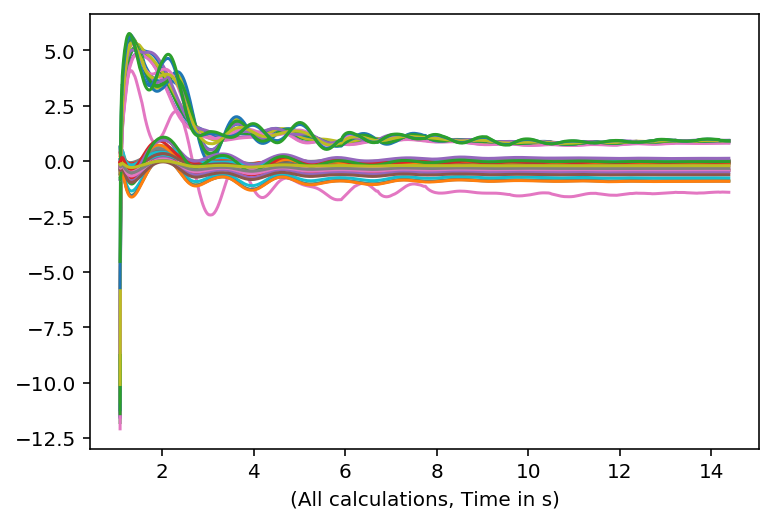

In [25]:
df.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [12]:
df1 = interpolation_reconstruction(df, 3000)

In [13]:
df1.head()

All calculations                        B_L03                        \
         Time in s Electrical Frequency in p.u. u1, Magnitude in p.u.   
0         1.080383                   -10.239137             -0.099205   
1         1.120036                     1.132558             -0.008013   
2         1.159689                     2.649154             -0.048967   
3         1.199342                     3.531000             -0.146544   
4         1.238995                     4.208801             -0.225571   

                         B_L04                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                   -11.795034              0.377146   
1                     1.137697              0.312641   
2                     2.557220              0.176203   
3                     3.442626             -0.017767   
4                     4.150185             -0.164437   

                         B_L07                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                   -11.545150              0.651569   
1                     1.116356              0.498837   
2                     2.265802              0.217751   
3                     3.056196             -0.190523   
4                     3.729457             -0.502154   

                         B_L08                        \
  Electrical Frequency in p.u. u1, Magnitude in p.u.   
0                   -11.532576              0.608276   
1                     1.063760              0.459849   
2                     2.145086              0.172707   
3                     2.927493             -0.248095   
4                     3.609516             -0.570673   

                         B_L12  ...             Trf Load_18  \
  Electrical Frequency in p.u.  ... Tap 1, Current Position   
0                    -9.004226  ...              -53.940137   
1                     1.829799  ...              -53.940137   
2                     3.410447  ...              -53.940137   
3                     4.184545  ...              -53.940137   
4                     4.720963  ...              -53.940137   

              Trf Load_20             Trf Load_21             Trf Load_23  \
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
0               -31.25212              -48.605229              -86.243297   
1               -31.25212              -48.605229              -86.243297   
2               -31.25212              -48.605229              -86.243297   
3               -31.25212              -48.605229              -86.243297   
4               -31.25212              -48.605229              -86.243297   

              Trf Load_24             Trf Load_25             Trf Load_26  \
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position   
0               -29.99868              -58.493684              -54.516747   
1               -29.99868              -58.493684              -54.516747   
2               -29.99868              -58.493684              -54.516747   
3               -29.99868              -58.493684              -54.516747   
4               -29.99868              -58.493684              -54.516747   

              Trf Load_27             Trf Load_28             Trf Load_29  
  Tap 1, Current Position Tap 1, Current Position Tap 1, Current Position  
0              -55.767185              -35.172757              -48.393869  
1              -55.767185              -35.172757              -48.393869  
2              -55.767185              -35.172757              -48.393869  
3              -55.767185              -35.172757              -48.393869  
4              -55.767185              -35.172757              -48.393869  

[5 rows x 250 columns]

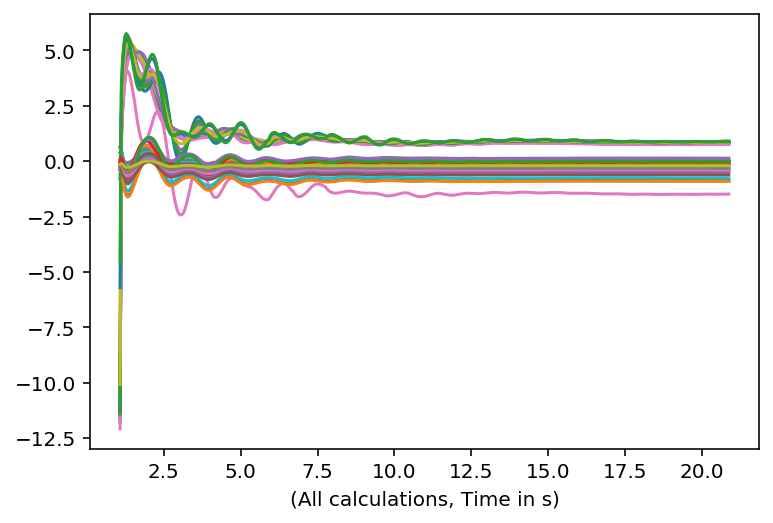

In [26]:
df1.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [15]:
def interpolation_reconstruction_nearest(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='nearest')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [16]:
df2 = interpolation_reconstruction_nearest(df, 3000)

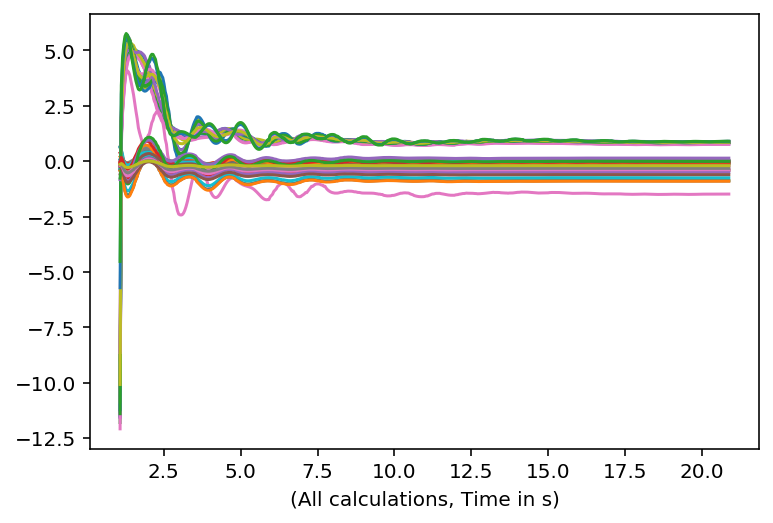

In [27]:
df2.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [18]:
def interpolation_reconstruction_zero(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='zero')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [19]:
df3 = interpolation_reconstruction_zero(df, 3000)

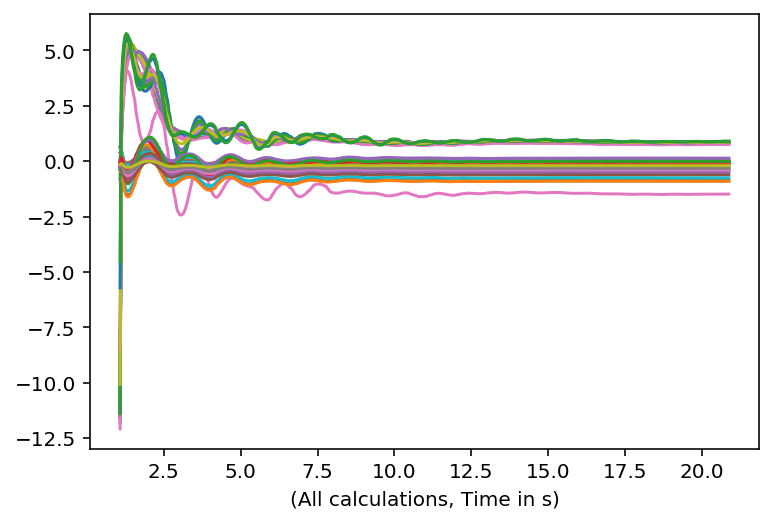

In [28]:
df3.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

In [21]:
def interpolation_reconstruction_slinear(df: pd.DataFrame, ngrid: int = 3000) -> pd.DataFrame:
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y, kind='slinear')
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame(
            {('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations', 'Time in s'))
           for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [22]:
df4 = interpolation_reconstruction_zero(df, 3000)

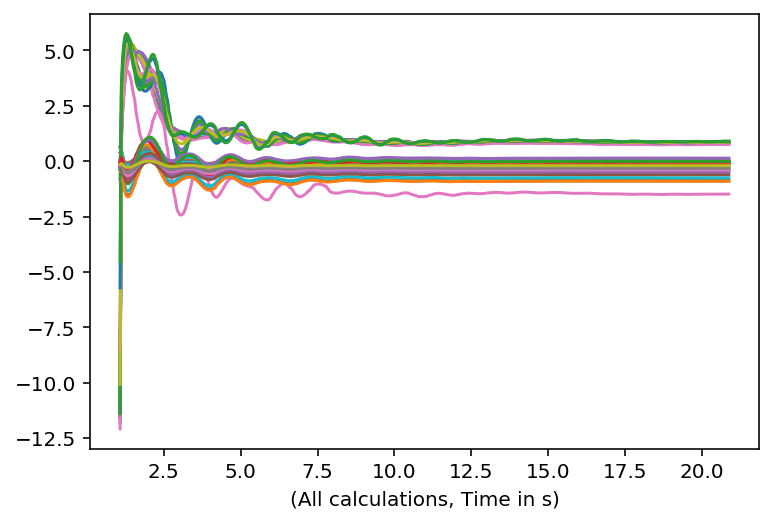

In [29]:
df4.iloc[:500,0:50].astype(float).plot(x=('All calculations','Time in s'), legend = False)

### After testing on several simulations, the spline interpolation of 1rst order seems to yield best results.